# Praca domowa 2, cz. 2

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import PIL.Image
from skimage.metrics import structural_similarity as ssim
import pytesseract

import os
import re
import cv2

from wordcloud import WordCloud, STOPWORDS
from textstat import lexicon_count
from textstat import flesch_reading_ease
from textstat import flesch_kincaid_grade
from textstat import sentence_count
from textstat import lexicon_count
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en import English
import spacy
from spacy.lang.en.examples import sentences 
import en_core_web_md

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

ModuleNotFoundError: No module named 'cv2'

In [2]:
src_chexpert = "F:/wb/" #katalog, w którym znajdują się pliki z danymi
src_china = "F:/wb/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/"

In [3]:
chexpert = pd.read_csv(src_chexpert + "CheXpert-v1.0-small/train.csv")

# Dodajemy dane pacjentów
chexpert['Patient'] = chexpert['Path'].str.split('/').apply(lambda x: x[2]).str.replace('patient', '')
chexpert.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
3         Lateral   NaN         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           NaN          NaN    NaN            NaN        NaN          NaN   
1           1.0          NaN   -1.0           -1.0        NaN         -1.0   
2           1.0          NaN    NaN           -1.0        NaN          NaN   
3           1.0          NaN    NaN           -1.0        NaN          NaN   
4           NaN          NaN    1.0            NaN        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  \
0           0.0               NaN            NaN       NaN              1.0   
1           NaN              -1.0            NaN       1.0              NaN   
2           NaN               NaN            NaN       1.0              NaN   
3           NaN               NaN            NaN       1.0              NaN   
4           0.0               NaN            NaN       NaN              NaN   

  Patient  
0   00001  
1   00002  
2   00002  
3   00002  
4   00003

In [105]:
chexpert['Path'][:5]

0    CheXpert-v1.0-small/train/patient00001/study1/...
1    CheXpert-v1.0-small/train/patient00002/study2/...
2    CheXpert-v1.0-small/train/patient00002/study1/...
3    CheXpert-v1.0-small/train/patient00002/study1/...
4    CheXpert-v1.0-small/train/patient00003/study1/...
Name: Path, dtype: object

In [106]:
china_path = ['CXR_png/' + name for name in os.listdir(src_china + "CXR_png") if name.startswith('CHNCXR')]
china_path[:5]

['CXR_png/CHNCXR_0001_0.png',
 'CXR_png/CHNCXR_0002_0.png',
 'CXR_png/CHNCXR_0003_0.png',
 'CXR_png/CHNCXR_0004_0.png',
 'CXR_png/CHNCXR_0005_0.png']

## Porównanie zdjęć z wybranych baz danych

In [107]:
chexpert_samples_idx = np.random.randint(0, len(chexpert), 16)
china_samples_idx = np.random.randint(0, len(china_path), 16)

### CheXpert

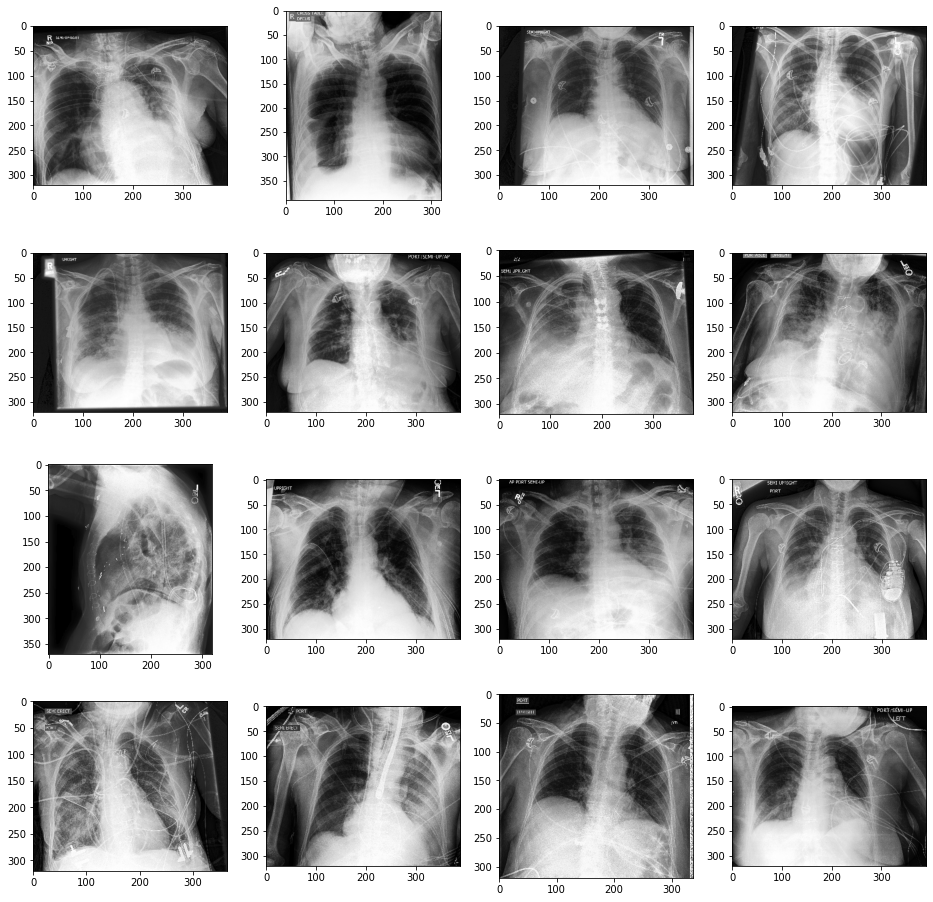

In [138]:
m, n = 4, 4
fig, axes = plt.subplots(m, n, figsize=(n * n, m * m))
k = 0
for i in range(m):
    for j in range(n):
        img = cv2.imread(src_chexpert + chexpert['Path'][chexpert_samples_idx[k]])
        k += 1
        axes[i, j].imshow(img)

### China

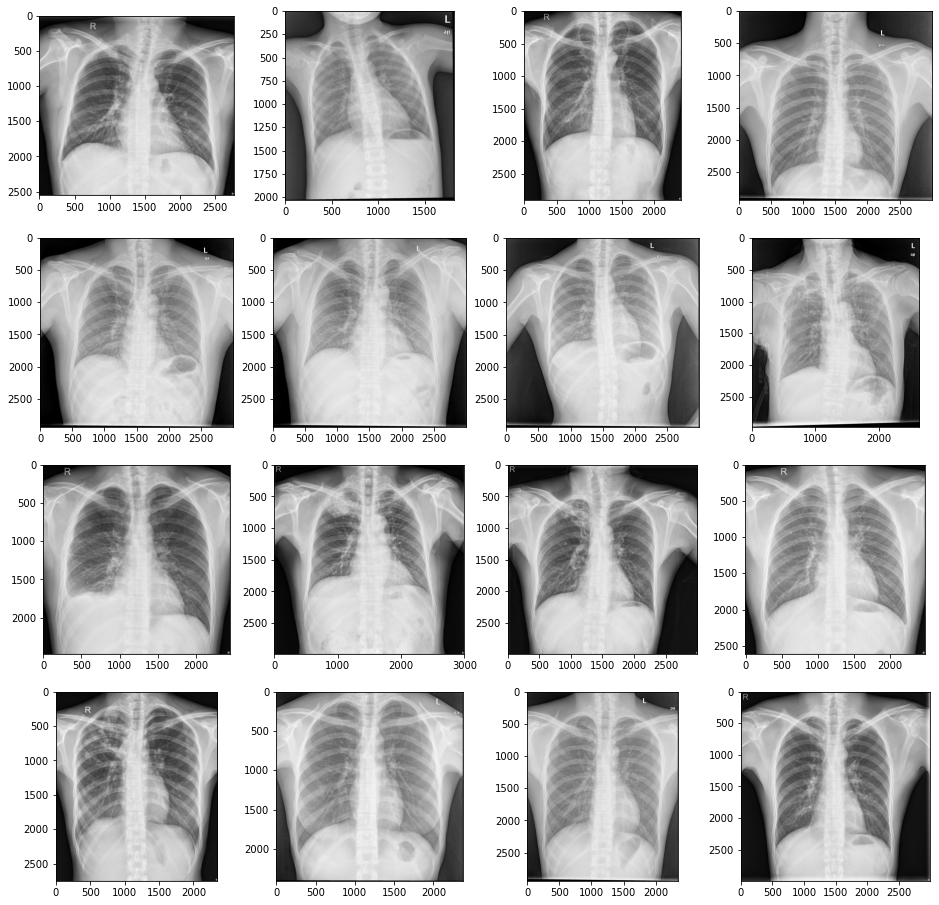

In [153]:
m, n = 4, 4
fig, axes = plt.subplots(m, n, figsize=(n * n, m * m))
k = 0
for i in range(m):
    for j in range(n):
        img = mpimg.imread(src_china + china_path[china_samples_idx[k]])
        k += 1
        axes[i, j].imshow(img)

## Rozmiary zdjęć

Na próbce 250 zdjęć sprawdzimy, jaka jest szerokość i wysokość typowego zdjęcia.

### CheXpert

In [9]:
width, height = [], []
for chexpert_image_path in chexpert['Path'].sample(250):
    chexpert_image = mpimg.imread(src_chexpert + chexpert_image_path)
    width.append(chexpert_image.shape[0])
    height.append(chexpert_image.shape[1])

<AxesSubplot:>

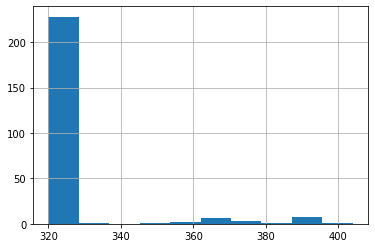

In [133]:
pd.Series(width).hist()

<AxesSubplot:>

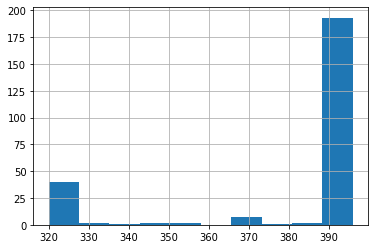

In [132]:
pd.Series(height).hist()

In [12]:
pd.Series(width).value_counts(normalize = True)[:3]

320    0.908
390    0.028
369    0.012
dtype: float64

In [13]:
pd.Series(height).value_counts(normalize = True)[:3]

390    0.652
320    0.160
389    0.116
dtype: float64

Zdjęcia w zbiorze danych CheXpert różnią się rozmiarami, ale dominują wymiary ok. $320 \times 320$ lub $320 \times 390$. Są to zdjęcia trzykanałowe.

In [14]:
cv2.imread(src_chexpert + chexpert['Path'][np.random.randint(0, len(chexpert))]).shape

(320, 390, 3)

### ChinaSet

In [15]:
china_width, china_height = [], []
for i in np.random.randint(0, len(china_path), 250):
    china_image = mpimg.imread(src_china + china_path[i])
    china_width.append(china_image.shape[0])
    china_height.append(china_image.shape[1])

<AxesSubplot:>

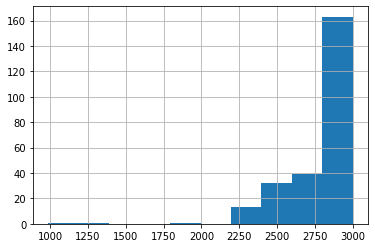

In [134]:
pd.Series(china_width).hist()

<AxesSubplot:>

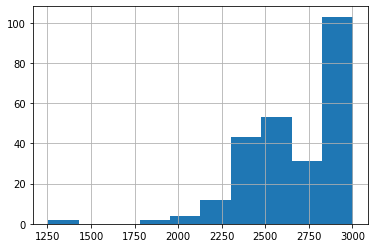

In [135]:
pd.Series(china_height).hist()

W zbiorze ChinaSet obrazy jeszcze bardziej różnią się rozmiarem, ale zasadniczo zarówno wysokość, jak i szerokość mieszczą się w przedziale od $2000$ do maksymalnie $3000$.

## Histogramy, wykresy gęstości dla pikseli

### CheXpert

In [109]:
#chexpert_hist_samples_idx = np.random.randint(0, len(chexpert), 50)
chexpert_hist_samples_idx = np.array([ 52261, 53275, 24121, 146933, 35093, 200608, 60088, 125876,187319, 94006, 180625, 182294, 183165, 98140, 220821, 202011,181619, 215001, 99455, 129473, 143524, 191372, 209461, 208016,28677, 163735, 134523, 177904, 149170, 56210, 179292, 195685,170647, 12163, 125157, 174335, 64606, 171654, 71194, 74761,218563, 160533, 214897, 149227, 53309, 82764, 1761, 100099,193966, 118072])
chexpert_hist_samples_idx

array([ 52261,  53275,  24121, 146933,  35093, 200608,  60088, 125876,
       187319,  94006, 180625, 182294, 183165,  98140, 220821, 202011,
       181619, 215001,  99455, 129473, 143524, 191372, 209461, 208016,
        28677, 163735, 134523, 177904, 149170,  56210, 179292, 195685,
       170647,  12163, 125157, 174335,  64606, 171654,  71194,  74761,
       218563, 160533, 214897, 149227,  53309,  82764,   1761, 100099,
       193966, 118072])

In [110]:
chexpert_sample_images = []
for i in chexpert_hist_samples_idx:
    chexpert_sample_images.append(cv2.imread(src_chexpert + chexpert['Path'][i]))

Histogramy dla 16 losowo wybranych obrazów:

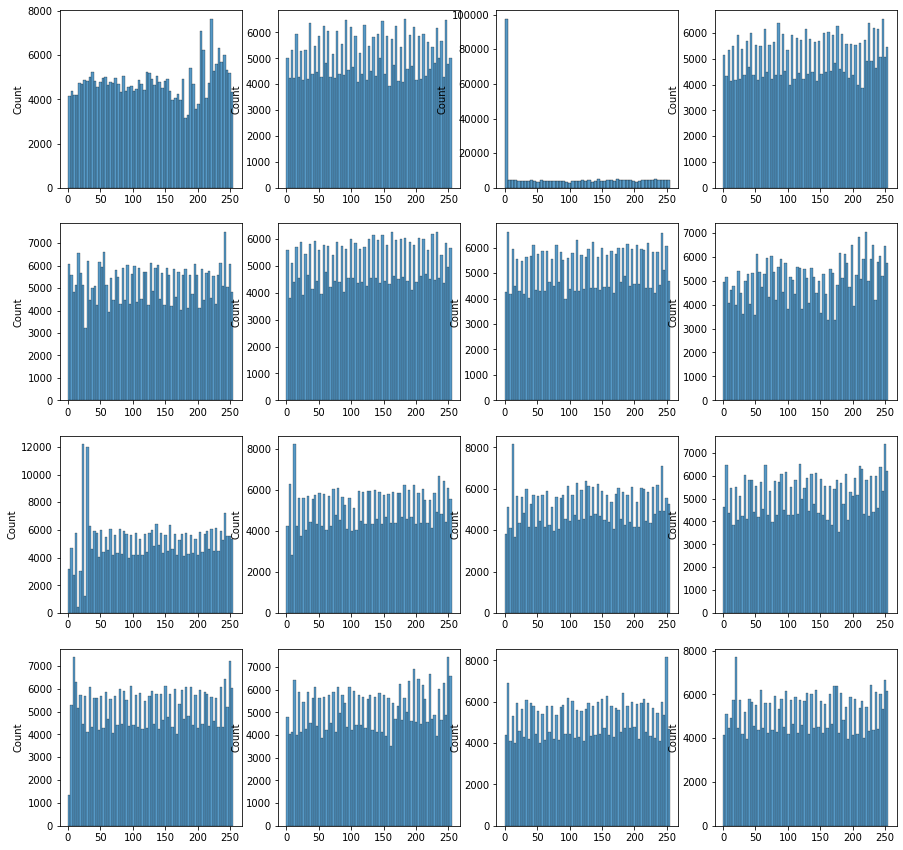

In [111]:
fig, ax = plt.subplots(4, 4, figsize=(15,15))
for i in range(4):
    for j in range(4):
        sns.histplot(chexpert_sample_images[i*4+j].flatten(), ax = ax[i, j])

Zbiorczy rozkład gęstości (dla 50 losowo wybranych próbek, w tym 16, dla których powyżej wyświetlono histogram).

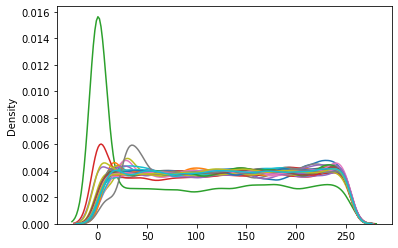

In [21]:
for image_ in chexpert_sample_images:
    sns.kdeplot(image_.flatten())

Piksele są z przedziału $[0, 255]$ i częstość występowania poszczególnych pikseli jest niemal identyczna. Tylko w jednym przypadku piksel zerowy występował znacznie częściej (zdjęcie nr 3, na wykresie gęstości jest to kolor zielony).

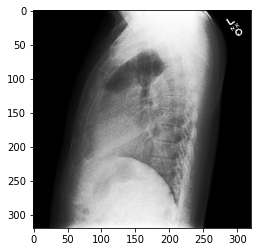

In [112]:
plt.imshow(chexpert_sample_images[2])

Duża liczba koloru czarnego jest jednak w tym konkretnym przypadku związana z techniką wykonania zdjęcia (z boku), a nie z chorobą. Biorąc pod uwagę powyższe, możemy stwierdzić, że po histogramie nie jesteśmy w stanie określić przynależności do żadnej z klas.

### Czy mamy podstawy sądzić, że np. zaznaczono tylko jedną zmianę/chorobę zamiast wszystkich? 

Tak, w zbiorze CheXpert jest to prawdopodobne z uwagi na liczne, powtarzające się, podobnego rodzaju braki danych (szczegółowo analizowałem tę kwestię w pracy domowej nr 1).

### Czy na obrazach występują litery, artefakty, aparatura medyczna?

Tak, w przypadku zbioru CheXpert litery występują bardzo często, główne *L* i *R*, ale również inne, mniej wyraźne annotacje.

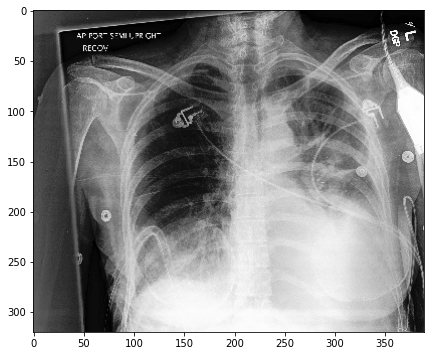

In [114]:
plt.figure(figsize=(7,7))
plt.imshow(cv2.imread((src_chexpert + chexpert['Path'][177641])))

Zauważmy, że wykrycie tych napisów nie jest możliwe za pomocą gotowych bibliotek:

In [140]:
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe"
img = PIL.Image.open(src_chexpert + chexpert['Path'][177641])
text = pytesseract.image_to_string(img)
pytesseract.image_to_string(img)

''

Na niektórych zdjęciach widać również aparaturę medyczną.

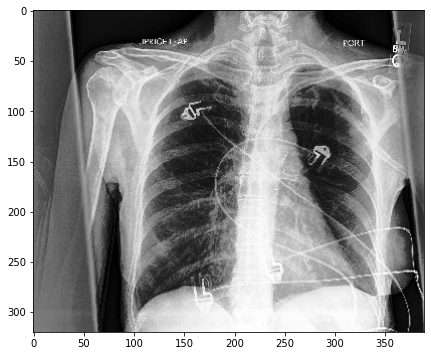

In [115]:
plt.figure(figsize=(7,7))
plt.imshow(cv2.imread((src_chexpert + chexpert['Path'][95766])))

In [141]:
img = PIL.Image.open(src_chexpert + chexpert['Path'][177641])
text = pytesseract.image_to_string(img)
pytesseract.image_to_string(img)

''

Niektóre zdjęcia są natomiast całkowicie czyste i przedstawiają jedynie płuca, bez żadnych dopisków ani innych przedmiotów.

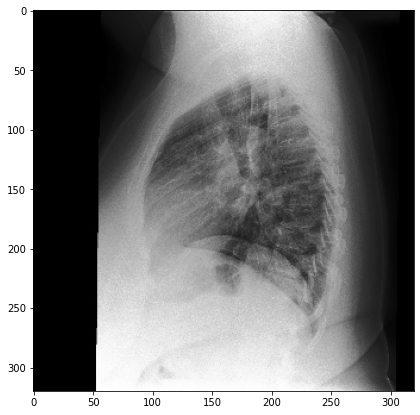

In [116]:
plt.figure(figsize=(7,7))
plt.imshow(cv2.imread((src_chexpert + chexpert['Path'][12103])))

### Maski

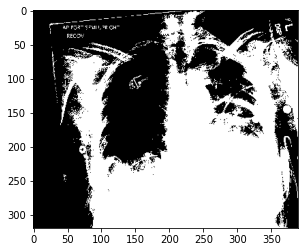

In [82]:
img_ = cv2.imread((src_chexpert + chexpert['Path'][177641]))
plt.imshow(img_ // 128 * 255)

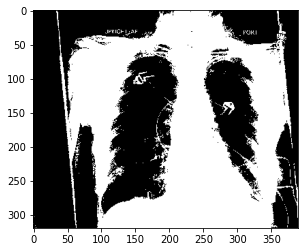

In [83]:
img_ = cv2.imread((src_chexpert + chexpert['Path'][95766]))
plt.imshow(img_ // 128 * 255)

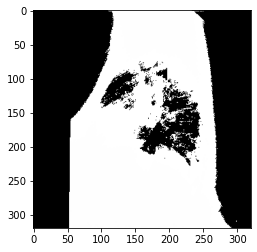

In [100]:
img_ = cv2.imread((src_chexpert + chexpert['Path'][12103]))
plt.imshow(img_ // 85 * 255)

### Napisy w ChinaSet

W przypadku ChinaSet, na podstawie wcześniej przedstawionych 16 losowych przykładów możemy stwierdzić, że zasadą jest obecność litery *L* albo *R* oraz brak jakichkolwiek innych dopisków.

### Różnice pomiędzy zdjęciami tego samego pacjenta

In [119]:
p_12333 = chexpert[chexpert['Patient'] == "12333"]
p_12333

Path     Sex  Age  \
50638  CheXpert-v1.0-small/train/patient12333/study1/...  Female   46   
50639  CheXpert-v1.0-small/train/patient12333/study1/...  Female   46   
50640  CheXpert-v1.0-small/train/patient12333/study1/...  Female   46   

      Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  \
50638         Frontal    PA         NaN                         NaN   
50639         Lateral   NaN         NaN                         NaN   
50640         Lateral   NaN         NaN                         NaN   

       Cardiomegaly  Lung Opacity  Lung Lesion  Edema  Consolidation  \
50638           NaN           NaN          NaN    NaN            NaN   
50639           NaN           NaN          NaN    NaN            NaN   
50640           NaN           NaN          NaN    NaN            NaN   

       Pneumonia  Atelectasis  Pneumothorax  Pleural Effusion  Pleural Other  \
50638        NaN          1.0           0.0               1.0            NaN   
50639        NaN          1.0           0.0               1.0            NaN   
50640        NaN          1.0           0.0               1.0            NaN   

       Fracture  Support Devices Patient  
50638       NaN              NaN   12333  
50639       NaN              NaN   12333  
50640       NaN              NaN   12333

In [127]:
image1 = cv2.imread(src_chexpert + p_12333['Path'].iloc[0])
image2 = cv2.imread(src_chexpert + p_12333['Path'].iloc[1])
image3 = cv2.imread(src_chexpert + p_12333['Path'].iloc[2])

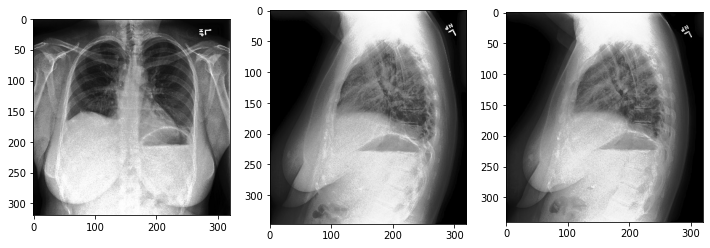

In [121]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(image3)

In [122]:
[image.shape for image in (image1, image2, image3)]

[(320, 321, 3), (347, 320, 3), (340, 320, 3)]

In [123]:
diff = image2[:340] - image3[:340]

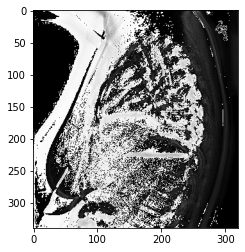

In [124]:
plt.imshow(diff)

### Podobieństwo między zdjęciami

#### SSIM

(dla trójki zdjęć dla ostatniego pacjenta)

In [32]:
print("1 vs. 2: " + str(ssim(image1[:320, :320], image2[:320, :320], channel_axis = 2)))
print("1 vs. 3: " + str(ssim(image1[:320, :320], image3[:320, :320], channel_axis = 2)))
print("2 vs. 3: " + str(ssim(image2[:320, :320], image3[:320, :320], channel_axis = 2)))

1 vs. 2: 0.2000890480027815
1 vs. 3: 0.19753757074795977
2 vs. 3: 0.5199961819489789


Między 2 i 3 zdjęciem wskaźnik prawidłowo wskazuje na wysokie podobieństwo.

#### Dla zdjęć z tej samej klasy

Najpierw wybierzmy 6 identycznie sklasyfikowanych rekordów, np. `Lung Opacity` = 1, `Pleural Effusion` = 1, `Support Devices` = 1.

In [72]:
chexpert_ident = chexpert.iloc[[1013, 1018, 1089, 1224, 1281, 1300]]
chexpert_ident

Path     Sex  Age  \
1013  CheXpert-v1.0-small/train/patient00249/study6/...  Female   61   
1018  CheXpert-v1.0-small/train/patient00249/study3/...  Female   61   
1089  CheXpert-v1.0-small/train/patient00259/study11...    Male   90   
1224  CheXpert-v1.0-small/train/patient00294/study16...  Female   36   
1281  CheXpert-v1.0-small/train/patient00310/study10...  Female   25   
1300  CheXpert-v1.0-small/train/patient00310/study40...  Female   25   

     Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  \
1013         Frontal    AP         NaN                         NaN   
1018         Frontal    AP         NaN                         NaN   
1089         Frontal    AP         NaN                         NaN   
1224         Frontal    AP         NaN                         NaN   
1281         Frontal    AP         NaN                         NaN   
1300         Frontal    AP         NaN                         NaN   

      Cardiomegaly  Lung Opacity  Lung Lesion  Edema  Consolidation  \
1013           NaN           1.0          NaN    NaN            NaN   
1018           NaN           1.0          NaN    NaN            NaN   
1089           NaN           1.0          NaN    NaN            NaN   
1224           NaN           1.0          NaN    NaN            NaN   
1281           NaN           1.0          NaN    NaN            NaN   
1300           NaN           1.0          NaN    NaN            NaN   

      Pneumonia  Atelectasis  Pneumothorax  Pleural Effusion  Pleural Other  \
1013        NaN          NaN           NaN               1.0            NaN   
1018        NaN          NaN           NaN               1.0            NaN   
1089        NaN          NaN           NaN               1.0            NaN   
1224        NaN          NaN           NaN               1.0            NaN   
1281        NaN          NaN           NaN               1.0            NaN   
1300        NaN          NaN           NaN               1.0            NaN   

      Fracture  Support Devices Patient  
1013       NaN              1.0   00249  
1018       NaN              1.0   00249  
1089       NaN              1.0   00259  
1224       NaN              1.0   00294  
1281       NaN              1.0   00310  
1300       NaN              1.0   00310

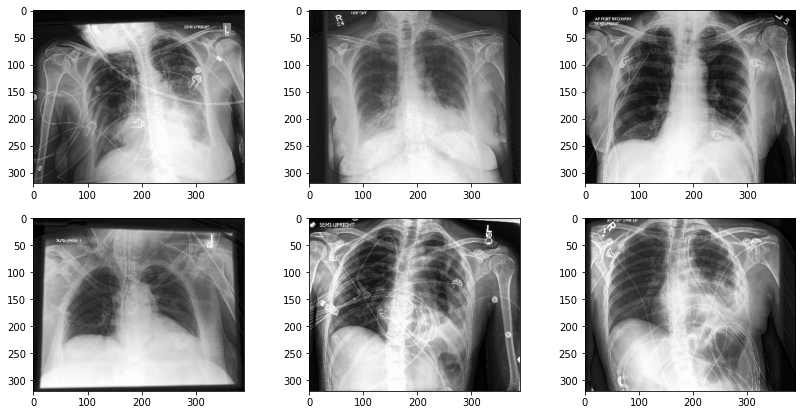

In [77]:
fig, ax = plt.subplots(2, 3, figsize=(14, 7))
ident_images = []
for i in range(6):
    ident_images.append(cv2.imread(src_chexpert + chexpert_ident.iloc[i, 0]))
    ax[i // 3, i % 3].imshow(ident_images[i])

Teraz liczymy SSIM:

In [82]:
for i in range(6):
    for j in range(i+1, 6):
        print(f"{i} vs. {j}: {ssim(ident_images[i][:, :389], ident_images[j][:, :389], channel_axis = 2)}")

0 vs. 1: 0.2547614247430211
0 vs. 2: 0.2041199931934794
0 vs. 3: 0.2647449982560345
0 vs. 4: 0.13024115625694524
0 vs. 5: 0.15557807461804035
1 vs. 2: 0.2666465303304113
1 vs. 3: 0.3166381909447598
1 vs. 4: 0.21129502753600157
1 vs. 5: 0.255807039885035
2 vs. 3: 0.2965546278644437
2 vs. 4: 0.20803258198476113
2 vs. 5: 0.21718636428100577
3 vs. 4: 0.20973341955483696
3 vs. 5: 0.21924000000890906
4 vs. 5: 0.2101252336761886


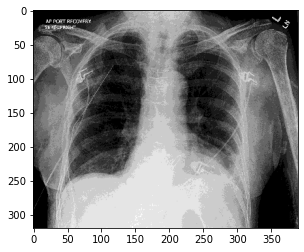

In [69]:
imt = cv2.imread(src_chexpert + chexpert['Path'][1089])
k = 10
imt = ((imt // (255/k)) * (255/k)).astype('int')
plt.imshow(imt)

## Główne obserwacje

* Zdjęcia są czarno-białe, a więc jednokanałowe (zarówno w CheXpert, jak i w ChinaSet).

* W obu zbiorach danych zdjęcia są w wysokiej jakości i nie są rozmazane.  W obu zbiorach danych mamy czarne tło.

* W zbiorze danych China zdjęcia są wykonywane frontalnie, w CheXpert - część frontalnie, a część z boku (informacje te znajdują się w bazie danych).

* W obu zbiorach danych zdjęcia są wykonywane w pionie. 

* W obu zbiorach danych nie występują dane personalne (imię i nazwisko), występuje za to informacja o wieku i płci pacjenta (szczegółowo przeanalizowałem to zagadnienie w pracy domowej nr 1).

* Wszystkie zdjęcia są na środku okna, nie występują takie, które wyraźnie byłyby poza tym środkiem (np. mocno z boku lub dołu).

* Na zdjęciach występują litery - głównie *L* i *R*, na niemal każdym zdjęciu ze zbioru ChinaSet oraz na większości zdjęć z CheXpert, co więcej w CheXpert występują inne dodatkowe adnotacje.

## Zależności

Zgodnie z wnioskami z pierwszej pracy domowej, braki danych zastępujemy zerami, a wartości -1 wartościami 0.5.

In [5]:
df_num = chexpert.copy()
df_num.iloc[:, 5:-1] = df_num.iloc[:, 5:-1].replace(-1, 0.5).fillna(0)

#### Zmienna `Age`

Najpierw podzielimy użytkowników na 5 równych grup, w zależności od wieku.

In [17]:
ages_qcut = pd.qcut(df_num['Age'], np.arange(0, 1.01, 1/5))
ages_qcut.value_counts(normalize = True)

(45.0, 57.0]      0.204455
(66.0, 77.0]      0.202297
(-0.001, 45.0]    0.201814
(57.0, 66.0]      0.199831
(77.0, 90.0]      0.191604
Name: Age, dtype: float64

Następnie sprawdzimy, w jakich grupach wiekowych najczęściej rozpoznawana była dana choroba (wartość 1).

In [18]:
diseases_by_age = pd.concat([ages_qcut[df_num[cname]==1].value_counts(normalize=True) for cname in df_num.columns[5:-1]], axis = 1)
diseases_by_age.columns = df_num.columns[5:-1]
diseases_by_age

No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
(-0.001, 45.0]    0.380412                    0.202908      0.153074   
(45.0, 57.0]      0.247531                    0.193091      0.174815   
(57.0, 66.0]      0.172423                    0.201982      0.187778   
(66.0, 77.0]      0.124704                    0.209576      0.209259   
(77.0, 90.0]      0.074930                    0.192443      0.275074   

                Lung Opacity  Lung Lesion     Edema  Consolidation  Pneumonia  \
(-0.001, 45.0]      0.170495     0.166776  0.139838       0.192518   0.202517   
(45.0, 57.0]        0.192355     0.200958  0.189392       0.185619   0.176188   
(57.0, 66.0]        0.204061     0.199978  0.199537       0.201921   0.183308   
(66.0, 77.0]        0.216014     0.236338  0.225434       0.215585   0.197052   
(77.0, 90.0]        0.217075     0.195950  0.245799       0.204356   0.240934   

                Atelectasis  Pneumothorax  Pleural Effusion  Pleural Other  \
(-0.001, 45.0]     0.168235      0.264706          0.150823       0.200681   
(45.0, 57.0]       0.210780      0.198169          0.193649       0.175135   
(57.0, 66.0]       0.211559      0.215086          0.210681       0.202100   
(66.0, 77.0]       0.219110      0.199815          0.226043       0.205223   
(77.0, 90.0]       0.190316      0.122223          0.218803       0.216861   

                Fracture  Support Devices  
(-0.001, 45.0]  0.201991         0.203490  
(45.0, 57.0]    0.200111         0.216714  
(57.0, 66.0]    0.182854         0.213912  
(66.0, 77.0]    0.184181         0.203102  
(77.0, 90.0]    0.230863         0.162783

W niemal każdym przypadku mamy wyniki także zbliżone do 20%, co sugeruje, że wiek nie ma wpływu na częstość występowania danej choroby. Jedynie w przypadku `No Finding` wartość 1 znacznie częściej pojawiała się w młodszych rocznikach, aniżeli w starszych. Oznacza to, iż zmienna `Age` może zaburzyć wynik działania algorytmu, zbyt często błędnie wskazując wartość 1 w `No Finding`. Zasadne wydaje się zatem usunięcie kolumny `No Finding` - tym bardziej, że nie niesie ona żadnych istotnych informacji (jak wyżej stwierdziliśmy, brak danych będziemy uznawać za brak choroby, a zatem same zera są równoznaczne z "No Finding").

In [19]:
df_num = df_num.drop(columns = ['No Finding'])
df_num.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP                         0.0           0.0   
1         Frontal    AP                         0.0           0.5   
2         Frontal    AP                         0.0           0.0   
3         Lateral   NaN                         0.0           0.0   
4         Frontal    AP                         0.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           0.0          0.0    0.0            0.0        0.0          0.0   
1           1.0          0.0    0.5            0.5        0.0          0.5   
2           1.0          0.0    0.0            0.5        0.0          0.0   
3           1.0          0.0    0.0            0.5        0.0          0.0   
4           0.0          0.0    1.0            0.0        0.0          0.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  \
0           0.0               0.0            0.0       0.0              1.0   
1           0.0               0.5            0.0       1.0              0.0   
2           0.0               0.0            0.0       1.0              0.0   
3           0.0               0.0            0.0       1.0              0.0   
4           0.0               0.0            0.0       0.0              0.0   

  Patient  
0   00001  
1   00002  
2   00002  
3   00002  
4   00003

#### Zmienna `Frontal`

Wyznaczymy odsetek wystąpień poszczególnych chorób dla zdjęć wykonywanych z przodu i podzielimy przez taki sam odsetek dla zdjęć wykonywanych z tyłu.

In [20]:
frontal = df_num[df_num['Frontal/Lateral'] == 'Frontal'].iloc[:, 5:-2] == 1
lateral = df_num[df_num['Frontal/Lateral'] == 'Lateral'].iloc[:, 5:-2] == 1
((frontal.sum() / len(frontal)) / (lateral.sum() / len(lateral))).sort_values()

Pleural Other                 0.417192
Lung Lesion                   0.556185
Pneumonia                     0.581090
Fracture                      0.785979
Enlarged Cardiomediastinum    0.966839
Cardiomegaly                  1.096743
Consolidation                 1.222865
Atelectasis                   1.378220
Pleural Effusion              1.403700
Lung Opacity                  1.404808
Pneumothorax                  1.709229
Edema                         3.275758
dtype: float64

Widzimy zatem, że prawdopodobieństwo stwierdzenia określonych chorób w większości przypadków jest uzależnione od tego, jak wykonywane było badanie.

#### Czy wystąpienie jednej choroby ma wpływ na ryzyko wystąpienia innej?

Występowanie poszczególnych chorób w całym zbiorze danych:

In [21]:
diseases = (df_num.iloc[:, 5:-2] == 1).sum()
diseases = diseases / df_num.shape[0]
diseases

Enlarged Cardiomediastinum    0.048332
Cardiomegaly                  0.120852
Lung Opacity                  0.472580
Lung Lesion                   0.041116
Edema                         0.233853
Consolidation                 0.066169
Pneumonia                     0.027031
Atelectasis                   0.149391
Pneumothorax                  0.087049
Pleural Effusion              0.385773
Pleural Other                 0.015769
Fracture                      0.040463
dtype: float64

Występowanie choroby $W$ (wiersze) w populacji rekordów ze stwierdzoną chorobą $K$ (kolumny):

In [22]:
dnames = list(df_num.columns[5:-2])
diseases_pairs = pd.DataFrame(columns = dnames, index = dnames)
for i in range(len(dnames)):
    for j in range(len(dnames)):
        diseases_pairs.loc[dnames[i], dnames[j]] = len(df_num[(df_num[dnames[i]] == 1) & (df_num[dnames[j]] == 1)]) / len(df_num[df_num[dnames[j]] == 1])
diseases_pairs = diseases_pairs.astype('float')
diseases_pairs

Enlarged Cardiomediastinum  Cardiomegaly  \
Enlarged Cardiomediastinum                    1.000000      0.070407   
Cardiomegaly                                  0.176051      1.000000   
Lung Opacity                                  0.472310      0.483296   
Lung Lesion                                   0.047138      0.023074   
Edema                                         0.197166      0.431815   
Consolidation                                 0.054177      0.053185   
Pneumonia                                     0.013891      0.018333   
Atelectasis                                   0.138081      0.141778   
Pneumothorax                                  0.071587      0.028778   
Pleural Effusion                              0.360067      0.438370   
Pleural Other                                 0.017874      0.012037   
Fracture                                      0.058992      0.029667   

                            Lung Opacity  Lung Lesion     Edema  \
Enlarged Cardiomediastinum      0.048304     0.055410  0.040750   
Cardiomegaly                    0.123592     0.067821  0.223156   
Lung Opacity                    1.000000     0.578707  0.525495   
Lung Lesion                     0.050350     1.000000  0.016575   
Edema                           0.260037     0.094274  1.000000   
Consolidation                   0.052794     0.081428  0.060368   
Pneumonia                       0.038122     0.049423  0.023045   
Atelectasis                     0.133982     0.111583  0.169276   
Pneumothorax                    0.085839     0.094274  0.028308   
Pleural Effusion                0.494388     0.355432  0.507618   
Pleural Other                   0.017797     0.033747  0.005819   
Fracture                        0.034201     0.037339  0.019312   

                            Consolidation  Pneumonia  Atelectasis  \
Enlarged Cardiomediastinum       0.039572   0.024839     0.044673   
Cardiomegaly                     0.097139   0.081967     0.114693   
Lung Opacity                     0.377055   0.666501     0.423837   
Lung Lesion                      0.050599   0.075178     0.030711   
Edema                            0.213353   0.199371     0.264981   
Consolidation                    1.000000   0.167909     0.060013   
Pneumonia                        0.068592   1.000000     0.018426   
Atelectasis                      0.135493   0.101838     1.000000   
Pneumothorax                     0.049990   0.024176     0.093810   
Pleural Effusion                 0.500778   0.286968     0.488075   
Pleural Other                    0.020294   0.020368     0.011655   
Fracture                         0.027126   0.023348     0.038381   

                            Pneumothorax  Pleural Effusion  Pleural Other  \
Enlarged Cardiomediastinum      0.039747          0.045111       0.054783   
Cardiomegaly                    0.039953          0.137329       0.092251   
Lung Opacity                    0.466012          0.605637       0.533352   
Lung Lesion                     0.044529          0.037883       0.087993   
Edema                           0.076049          0.307715       0.086290   
Consolidation                   0.037999          0.085895       0.085155   
Pneumonia                       0.007507          0.020107       0.034913   
Atelectasis                     0.160993          0.189008       0.110417   
Pneumothorax                    1.000000          0.077634       0.071814   
Pleural Effusion                0.344046          1.000000       0.261141   
Pleural Other                   0.013009          0.010674       1.000000   
Fracture                        0.053990          0.028496       0.084019   

                            Fracture  
Enlarged Cardiomediastinum  0.070465  
Cardiomegaly                0.088606  
Lung Opacity                0.399447  
Lung Lesion                 0.037942  
Edema                       0.111615  
Consolidation               0.044358  
Pneumonia                   0.015597  
Atelect

<AxesSubplot:>

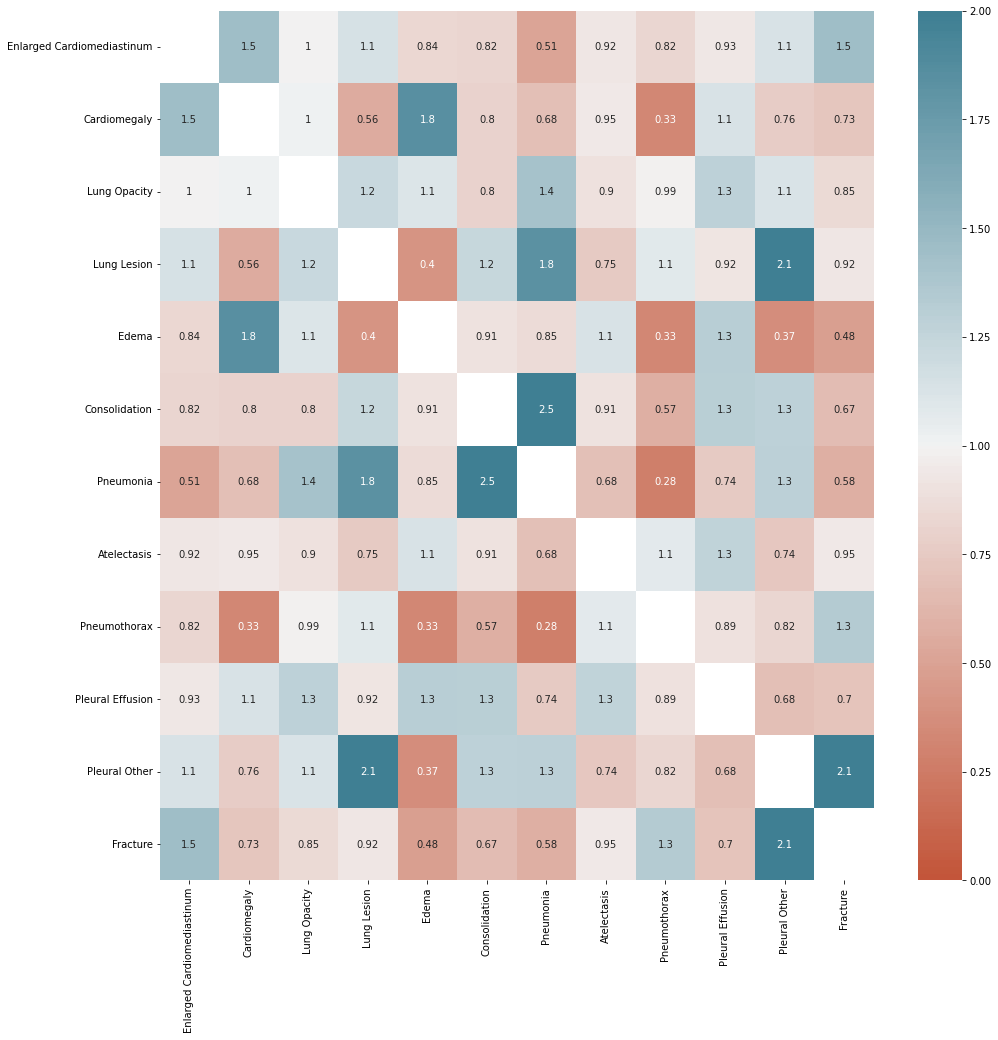

In [23]:
ratio = (diseases_pairs / np.tile(diseases.values[:, np.newaxis], len(dnames))).transpose()
plt.figure(figsize = (16,16))
sns.heatmap(ratio, mask = np.tril(ratio) * np.triu(ratio),
    annot=True,
    cmap=sns.diverging_palette(20, 220, n=200),
    vmin=0, vmax=2, center=1)

Widzimy zatem, że w wielu przypadkach jedne choroby zwiększają/zmniejszają prawdopodobieństwo stwierdzenia innych. Na przykład zapalenie płuc (Pneumonia) zwiększa 2,5-krotnie prawdopodobieństwo, że wystąpi konsolidacja (Consolidation), albowiem wśród wszystkich rekordów konsolidacja występowała z częstością 0.066169, ale wśród rekordów zawierających stwierdzone zapalenie płuc - już z częstością 0.167909.

### Zmienna `AP/PA`

In [6]:
df_num_AP = df_num[df_num['AP/PA'] == 'AP']
df_num_PA = df_num[df_num['AP/PA'] == 'PA']

Średnie wartości poszczególnych kolumn w zależności od `AP/PA`.

In [17]:
df_num_AP.iloc[:, 5:-1].mean()

No Finding                    0.070988
Enlarged Cardiomediastinum    0.074036
Cardiomegaly                  0.143929
Lung Opacity                  0.533189
Lung Lesion                   0.032750
Edema                         0.330803
Consolidation                 0.137787
Pneumonia                     0.063927
Atelectasis                   0.246497
Pneumothorax                  0.105421
Pleural Effusion              0.449910
Pleural Other                 0.012457
Fracture                      0.038415
Support Devices               0.615174
dtype: float64

In [18]:
df_num_PA.iloc[:, 5:-1].mean()

No Finding                    0.186914
Enlarged Cardiomediastinum    0.080404
Cardiomegaly                  0.118236
Lung Opacity                  0.348895
Lung Lesion                   0.078246
Edema                         0.072349
Consolidation                 0.098810
Pneumonia                     0.079334
Atelectasis                   0.163732
Pneumothorax                  0.068389
Pleural Effusion              0.305269
Pleural Other                 0.047434
Fracture                      0.050170
Support Devices               0.279351
dtype: float64

Iloraz:

In [21]:
(df_num_AP.iloc[:, 5:-1].mean() / df_num_PA.iloc[:, 5:-1].mean()).sort_values(ascending = False)

Edema                         4.572343
Support Devices               2.202157
Pneumothorax                  1.541496
Lung Opacity                  1.528220
Atelectasis                   1.505491
Pleural Effusion              1.473818
Consolidation                 1.394459
Cardiomegaly                  1.217304
Enlarged Cardiomediastinum    0.920796
Pneumonia                     0.805801
Fracture                      0.765700
Lung Lesion                   0.418546
No Finding                    0.379792
Pleural Other                 0.262629
dtype: float64

Widzimy, że informacja o sposobie wykonania zdjęcia ma wpływ na prawdopodobieństwo stwierdzenia poszczególnych chorób, np. przy zdjęciach wykonywanych techniką AP mamy ponad 4 razy więcej stwierdzeń Edema (obrzęk).

## Dane tekstowe (ChinaSet)

In [23]:
src_text = "F:/wb/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/"

In [24]:
content = []
for (dirpath, dirnames, filenames) in os.walk(src_text):
    filenames = filenames
for filename in filenames:
    with open(src_text + filename, mode = 'r') as f:
        content.append([filename.split('_')[1], f.read()])
china = pd.DataFrame(content, columns = ['id', 'content'])
china['content'] = china['content'].str.lower().str.replace("\n", " ").str.replace("\t", "")
china

id                                            content
0    0001                                  male 45yrs normal
1    0002                                  male 63yrs normal
2    0003                               female 48yrs normal 
3    0004                                 male 58yrs  normal
4    0005                                  male 28yrs normal
..    ...                                                ...
657  0658  male 41yrs   bilateral secondary ptb  with rig...
658  0659  male , 33yrs   secondary ptb  in the left uppe...
659  0660  male , 50yrs   1.bilateral secondary ptb  with...
660  0661  male, 26yrs   bilateral secondary ptb  with ri...
661  0662  male , 32yrs   secondary ptb  in the right upp...

[662 rows x 2 columns]

In [2]:
def stats(data, col):

    #characters
    data['len'] = data[col].str.len()
    #words
    data['words'] = data[col].apply(lambda x : lexicon_count(x,removepunct=True))
    #average sentence length
    data['avg_sen'] = data[col].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    #reading ease
    data['reading_ease'] = data[col].apply(lambda x : flesch_reading_ease(x))
    #flesch_kincaid_grade
    data['grade'] = data[col].apply(lambda x : flesch_kincaid_grade(x))
    #sentences
    data['sentences'] = data[col].apply(lambda x : sentence_count(x))
    
    return data

def dist(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
    sns.histplot(data = data, x = 'len', ax = ax1)
    sns.histplot(data['words'], ax = ax2)
    ax1.set_title('Rozkład liczby znaków w tekście')
    ax2.set_title('Rozkład liczby słów w tekście')
    plt.show()
def ease(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
    sns.histplot(data = data, x = 'reading_ease', ax = ax1)
    sns.histplot(data['grade'], ax = ax2)
    ax1.set_title('Flesh reading ease')
    ax2.set_title('Flesh-Kincaid grade level')
    plt.show()
def cleaning(data):

    # zmniejszenie liter
    data = data.apply(lambda x : x.lower())

    # usunięcie znaków specjalnych i cyfr
    data = data.apply(lambda x : re.sub(r'[^A-Za-z ]+', ' ', x))

    # wyrzucenie słów z XXXX
    data = data.apply(lambda x : re.sub(r'[A-Za-z]*xxxx[A-Za-z]*', '', x))
    
    return data

def vect(data):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data)
    return pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

# usuwanie stopwords

def stopw(data):

    nlp = English()
    stopwords = []
    for i in data.columns:
        lexeme = nlp.vocab[i]
        if lexeme.is_stop == True: stopwords.append(i)
    print(stopwords)
    print(len(stopwords))
    
    return stopwords, data.drop(stopwords, axis = 1)

# lematyzacja

def lem(data):

    nlp = en_core_web_md.load()

    listToStr = ' '.join([str(elem) for elem in ind_en.columns])
    doc = nlp(listToStr)

    i=0
    tokenDict = {}
    for token in doc:
        if (str(token) != str(token.lemma_)): 
            tokenDict[str(token)] = token.lemma_

    print(tokenDict)
    
    data.rename(columns = tokenDict, inplace = True)
    print(f"Number of unique columns: {len(data.columns.unique())}.")
    print(f"Number of columns: {len(data.columns)}.")

    # merge duplicated columns
    data = data.sum(axis=1, level=0)
    a, b = data.shape
    print(f"Number of rows after lemmatization:{a}, number of columns: {b}.")
    
    return data

def pop_words(data):

    most_pop_words = data.sum().sort_values(ascending=False).head(30)
    most_pop_words = pd.DataFrame(most_pop_words).reset_index()
    most_pop_words.columns = ['word', 'count']
    fig = plt.figure(figsize = (9, 6))
    sns.barplot(data = most_pop_words, x = 'word', y = 'count', color ='dodgerblue')
    plt.xticks(rotation=60)
    fig.suptitle('Most popular words in whole dataset', fontsize=18)
    plt.show()

stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

NameError: name 'STOPWORDS' is not defined

### Stopwords, wordcloud i najpopularniejsze słowa

In [103]:
china_words = vect(china['content'])
stopwords, china_words = stopw(china_words)

['after', 'and', 'in', 'most', 'the', 'with']
6


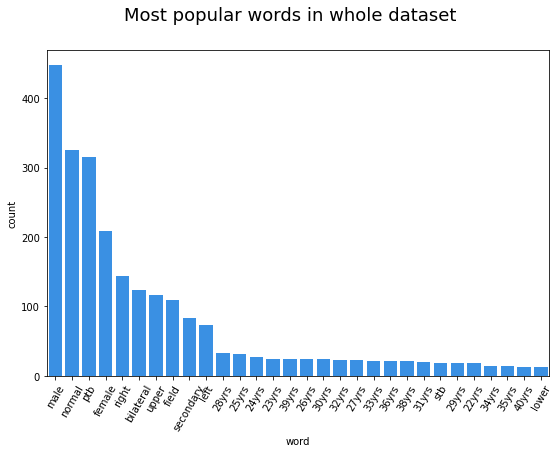

In [122]:
pop_words(china_words)

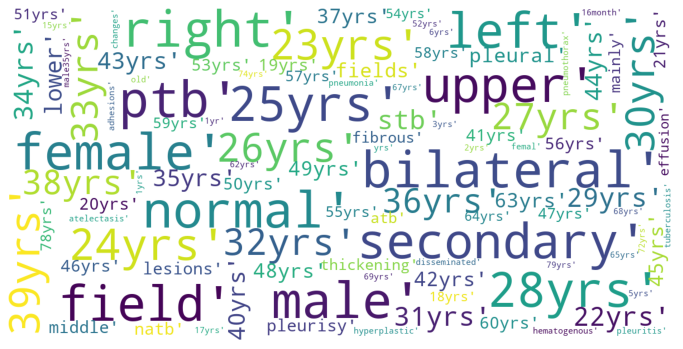

In [104]:
show_wordcloud(china_words.sum().sort_values(ascending=False).to_dict())

Przykładowe słowa opisujące choroby: *pleurisy*, *hematogenous*, *effusion*, *changes*, *adhesions*.

### Liczba słów i znaków w tekście

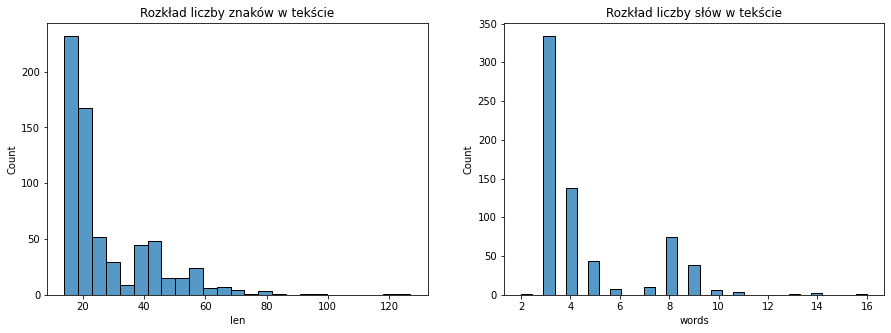

In [120]:
dist(china)

Długie opisy zasadniczo nie występują. Poniżej przykład długiego opisu (najdłuższego ze wszystkich):

In [31]:
china.iloc[np.argmax(china['content'].str.len())]['content']

'male , 50yrs   1.bilateral secondary ptb  with right upper atelectasis;2.right pleural adhesions;3.left compensatory emphysema '

### Flesh reading ease i Flesh-Kincaid grade level

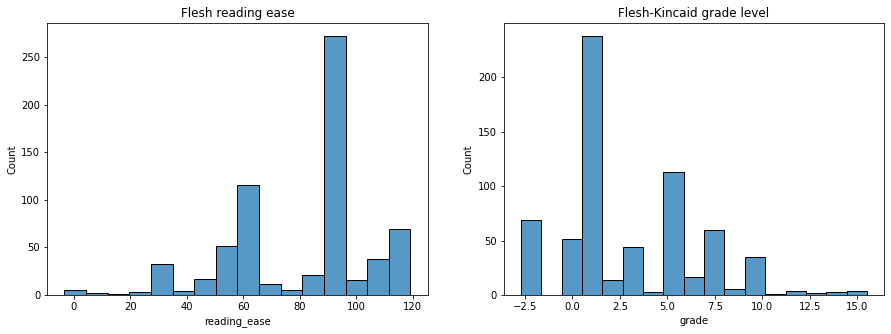

In [123]:
ease(china)

# Covid-19 Radiography Dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sewar.full_ref import ssim
import PIL
import cv2
import pytesseract
import matplotlib.image as mpimg
import seaborn as sns
import nibabel as nib


## Dane jakościowe

In [21]:
height = []
width = []
for i in range(1, 1000):
    img = PIL.Image.open(f"./COVID/COVID-{i}.png")
    w, h = img.size
    width.append(w)
    height.append(h)

<AxesSubplot:>

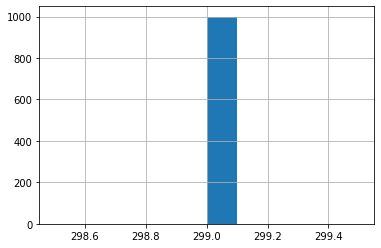

In [24]:
pd.Series(width).hist()

<AxesSubplot:>

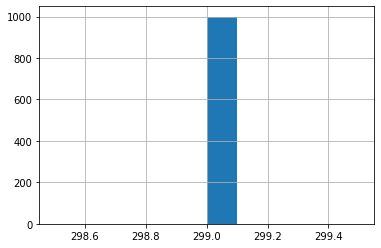

In [25]:
pd.Series(height).hist()

Wszystkie zdjęcia mają takie same wymiary.

## Artefakty na zdjęciach

W zbiorze znajdują się zdjęcia z łańcuszkami i innymi podobnymi przedmiotami.

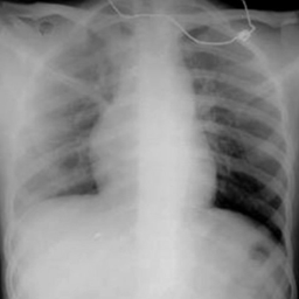

In [5]:
display(PIL.Image.open("./COVID/COVID-144.png"))


## Aparatura medyczna

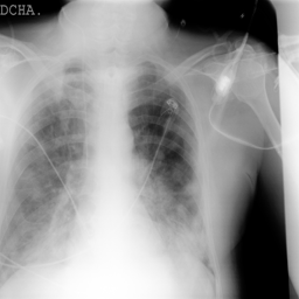

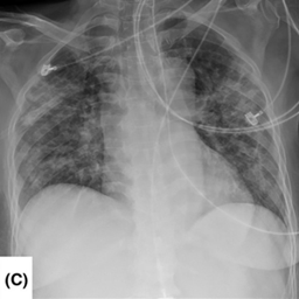

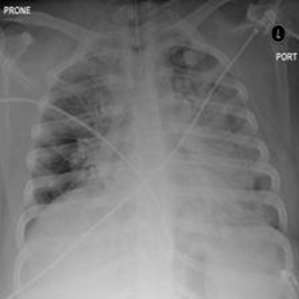

In [4]:
display(PIL.Image.open("./COVID/COVID-39.png"))
display(PIL.Image.open("./COVID/COVID-99.png"))
display(PIL.Image.open("./COVID/COVID-138.png"))

## Litery na obrazkach

Dla 500 covidowych pacjentów:

In [9]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

covid = 0
for i in range(1,500):
    img = PIL.Image.open(f"./COVID/COVID-{i}.png")
    text = pytesseract.image_to_string(img)
    if (text!=""):
        print(pytesseract.image_to_string(img))
        covid += 1
    

a

--

7

‘AFirst chestx-ray


a

i
az

_-

_-
ww A

,

ci

| SECONG ChESE May


| ey

° ‘


ay

#t

2020/02/18, D14

sl
i

ae

wal

LL

—
_

Aa)

(i)

P cae

nly

el

ry

—_ —
|

—

Pat

=

Q

=
q Re
A

=
q Re
A

A supine, aP


aN

:

vy

fy

ry

Lis

it

a

ar

| cm
= |

7%

~—


a

4

—_—



Dla 500 zdrowych pacjentów

In [14]:
normal = 0
for i in range(1,500):
    img = PIL.Image.open(f"./Normal/Normal-{i}.png")
    text = pytesseract.image_to_string(img)
    if (text!=""):
        print(pytesseract.image_to_string(img))
        normal += 1

a

AX

=
i
° e

Jy

ge’

iW

Dw
vs

om

TaN

’ 4 . LOOT

.
oA,

hls

Wa,

ptt Lt

ay

ay

ay

7

al

Fan
ma!

E

y

Yt |
>
ig

ay

Wak

)

go

aad

ail ie
ie

Roe
ae

ay

—

rT.
ms

Som

Va

i, Wi .

. Tal

4 iy
6

Vins

{ ee"
goal

«ie
pow.

ei, ie

wa

“yl

€ wel,
Z —_


————
tl

4s

. a,
—_———————

PN

bas.

a
OT

‘we
4 %

~S ,

‘wy,

, Lae 4,

Lhe

< i,
-_--

.

.

tT

Yi ,

ie

‘ —_—_
‘ TT al

Wey

ay

(a)

0
7

aN

A

BR. 4

zy

ay

a
Y Wi

a
——_ ~~

rN

7 A
MA

Wi

Da?

fl" 3

a - re
~ &

WM,

rh

a
A We 44


al

uy

Pi

———
Ty i ¥

se ge “= Wy?

ee
Wy,

bins

Wy, 7

sist»

if? »
° ji
—————

ay

Wy?

e &F

A OR
> wi

ps

Wa ; ;

wa

iY

“3

ZY

Pe

ay

_i

WY
PLLA 4

a
MOE

‘.

SA
ad

K Bu |



In [15]:
print("Liczba wykrytych napisów wśród 500 chorych: "+ str(covid))
print("Liczba wykrytych napisów wśród 500 zdrowych: "+ str(normal))

Liczba wykrytych napisów wśród chorych: 45
Liczba wykrytych napisów wśród zdrowych: 85


* Brak podziału na zbiór testowy i treningowy.
* Wszystkie zdjęcia są jednokanałowe
* Brak danych osobowych
* Wszystkie zdjęcia są podzielone na grupy według chorob które wykryto wśród tych pacjentów. Można przypuszczać, że osoby chore na covid mogą mieć jeszcze inne zaburzenia

## Analiza obszarów

## Histogramy

In [16]:
covid_sample_images = []
for i in range(1,100):
    photo = mpimg.imread(f'./COVID/COVID-{i}.png')
    covid_sample_images.append(photo)

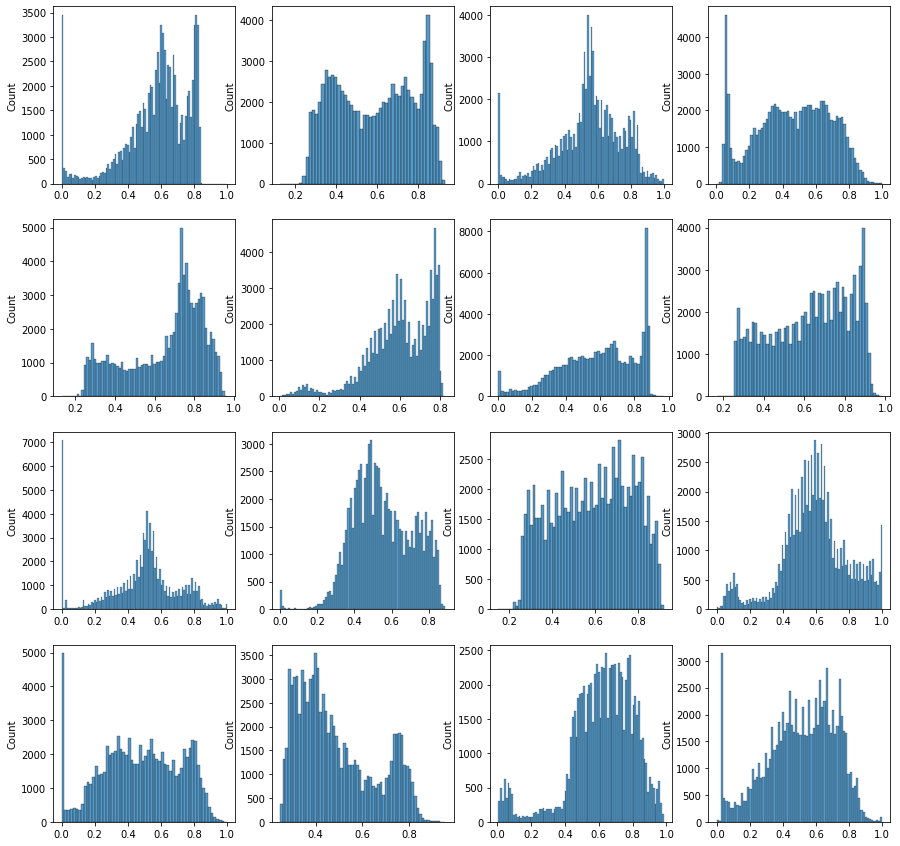

In [17]:
fig, ax = plt.subplots(4, 4, figsize=(15,15))
for i in range(4):
    for j in range(4):
        sns.histplot(covid_sample_images[i*4+j].flatten(), ax = ax[i, j])

Pixele są z zakresu 0 do 1

Jest wiele zdjęć z przesuniętym histogramem, widać to na podstawie przedstawionych powyżej histogramów.

## Reszta

Z powodu braku danych czy zdjęcia należą do jednego pacjenta porównamy zdjęcia z jednej grupy chorobowej.

In [45]:
images = []
for i in range(401,407):
    img = cv2.imread(f'./COVID/COVID-{i}.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(img)

for i in range(6):
    for j in range(i+1, 6):
        print(f"{i} vs. {j}: {ssim(images[i], images[j])}")
        

0 vs. 1: (0.4816793842728816, 0.5339401051400364)
0 vs. 2: (0.4594168741094419, 0.4827563342054115)
0 vs. 3: (0.5231600149368703, 0.5618642962278128)
0 vs. 4: (0.5470332913666559, 0.5747260884839066)
0 vs. 5: (0.4200833888324603, 0.46284123032329266)
1 vs. 2: (0.4424341239474482, 0.49442048089580243)
1 vs. 3: (0.5589241312768685, 0.5788812688422635)
1 vs. 4: (0.4721286883707166, 0.5264284243958556)
1 vs. 5: (0.5084959496578172, 0.5311600317895617)
2 vs. 3: (0.4473080115759652, 0.48239438814084673)
2 vs. 4: (0.4299722389758943, 0.46154081045923373)
2 vs. 5: (0.4637897993232496, 0.5029854982496746)
3 vs. 4: (0.4577464784046374, 0.5005208252450349)
3 vs. 5: (0.4797685170663624, 0.5017929701136943)
4 vs. 5: (0.43838674501556474, 0.49189270305128613)


# Covid 19 segmentation dataset

In [27]:
metadata = pd.read_csv("C:/Users/Mateusz/warsztatyzadanie1/segmentation/Test-Images-Clinical-Details.csv")
metadata.head()

SIRM Case  Slice position in .nii.gz  Patient age  \
0         1                       60.0         80.0   
1         2                        2.0         62.0   
2         2                       89.0          NaN   
3         3                       72.0         57.0   
4         3                       70.0          NaN   

   Patient Sex (Male = 0 Female = 1)  Unnamed: 4  Unnamed: 5  Unnamed: 6  
0                                0.0         NaN         NaN         NaN  
1                                0.0         NaN         NaN         NaN  
2                                NaN         NaN         NaN         NaN  
3                                0.0         NaN         NaN         NaN  
4                                NaN         NaN         NaN         NaN

In [28]:
cov_seg_images = nib.load('C:/Users/Mateusz/warsztatyzadanie1/segmentation/tr_im.nii')
cov_seg_masks = nib.load('C:/Users/Mateusz/warsztatyzadanie1/segmentation/tr_mask.nii')
images = cov_seg_images.get_fdata()
masks = cov_seg_masks.get_fdata()

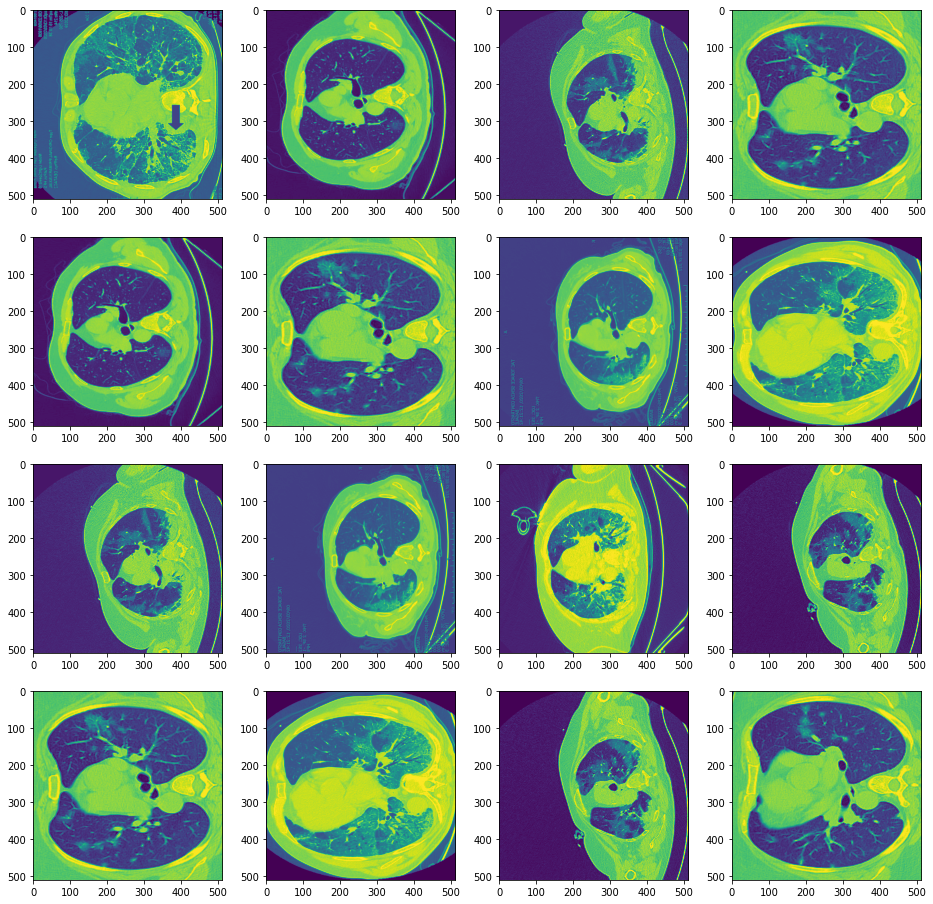

In [29]:
m, n = 4, 4
fig, axes = plt.subplots(m, n, figsize=(n * n, m * m))
for i in range(m):
    for j in range(n):
        image = images[:,:,(i+1)*(j+1)]
        axes[i, j].imshow(image)

Zdjęcia są trzy kanałowe

In [34]:
images.shape

(512, 512, 100)

Na zdjęciach trudno znaleźć artefakty, bądź aparatury medyczne. 

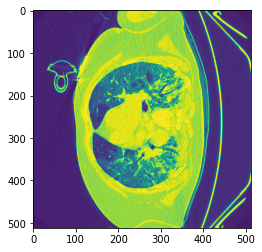

In [32]:
image = images[:,:,9]
plt.imshow(image)

Ten wystający element można uznać za coś nienaturalnego na zdjęciach medycznych.

## Rozmiary zdjęć

In [35]:
width, height = [], []
for i in range(100):
    image = images[:,:,i]
    width.append(image.shape[0])
    height.append(image.shape[1])

<AxesSubplot:>

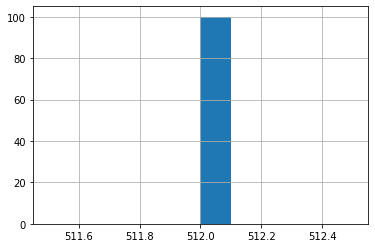

In [36]:
pd.Series(width).hist()

<AxesSubplot:>

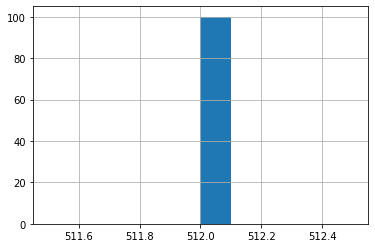

In [37]:
pd.Series(height).hist()

Wszystkie zdjęcia mają takie same wymiary.

## Dane osobowe

Wszystkie możliwe dane osobowe zostały usunięta. Pozostały jedynie informacje o płci i wieku pacjentów.

In [39]:
metadata["Patient age"].dropna().value_counts()

61.0    3
80.0    2
72.0    2
62.0    2
64.0    2
43.0    2
73.0    2
55.0    2
53.0    1
47.0    1
76.0    1
86.0    1
87.0    1
68.0    1
82.0    1
65.0    1
79.0    1
84.0    1
63.0    1
78.0    1
48.0    1
58.0    1
27.0    1
69.0    1
71.0    1
50.0    1
60.0    1
67.0    1
32.0    1
45.0    1
57.0    1
35.0    1
Name: Patient age, dtype: int64

In [40]:
metadata["Patient Sex (Male = 0 Female = 1)"].dropna().value_counts()

0.0     27
1.0     11
26.0     1
Name: Patient Sex (Male = 0 Female = 1), dtype: int64

## Histogramy / Wykresy gęstości 


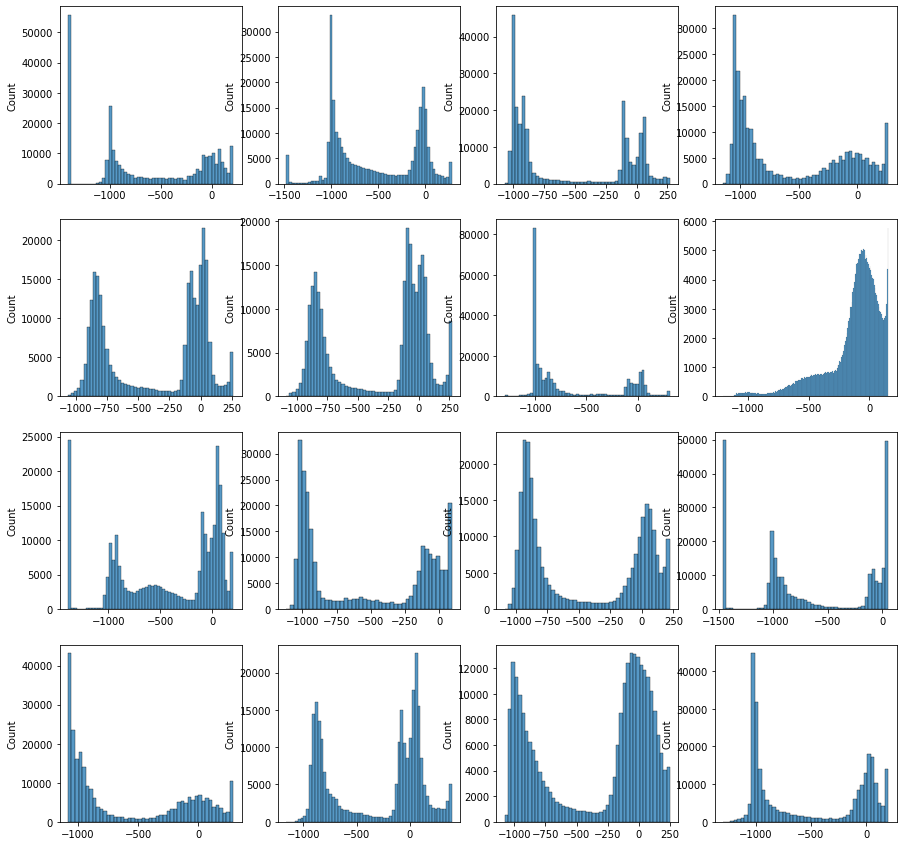

In [41]:
fig, ax = plt.subplots(4, 4, figsize=(15,15))
for i in range(4):
    for j in range(4):
        sns.histplot(images[:,:,i*4+j].flatten(), ax = ax[i, j])

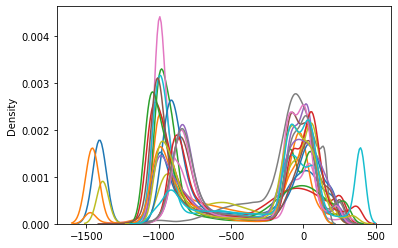

In [42]:
for i in range(20):
    sns.kdeplot(images[:,:,i].flatten())

Bardzo podobne rozkłady wśród zdjęć.

## Maski


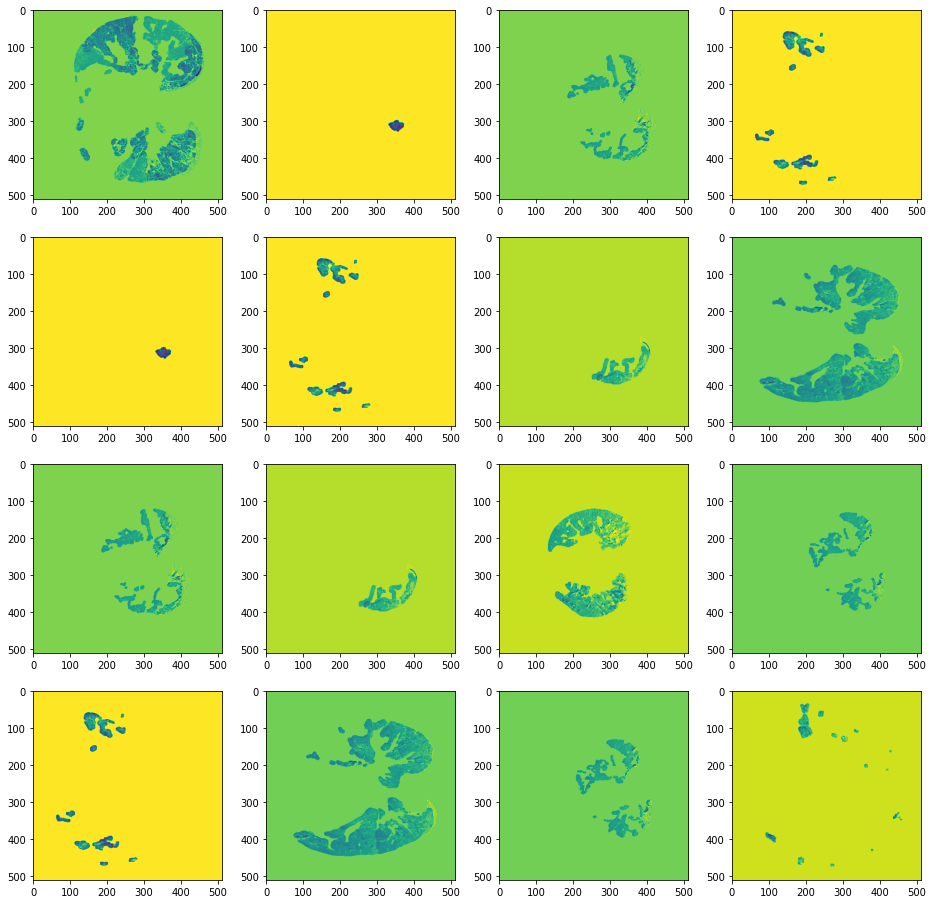

In [43]:
m, n = 4, 4
fig, axes = plt.subplots(m, n, figsize=(n * n, m * m))
for i in range(m):
    for j in range(n):
        image = images[:,:,(i+1)*(j+1)]
        mask = masks[:,:,(i+1)*(j+1)]
        axes[i, j].imshow(image*mask)

# Chest X-ray images Open-i

## ANALIZA TEKSTÓW

In [11]:
# utworzenie ramki danych
all_files = os. listdir('./ecgen-radiology')

d = {
    'COMPARISON' : [],
    'INDICATION' : [],
    'FINDINGS'   : [],
    'IMPRESSION' : [],
    'CAPTION'    : []
}

for f in all_files:
    file = minidom.parse('ecgen-radiology/' + f)
    
    caption = file.getElementsByTagName('caption')
    
    try:
        d['CAPTION'].append(caption[0].childNodes[0].data)
    except IndexError:
        d['CAPTION'].append(None)
    
    models = file.getElementsByTagName('AbstractText')
    
    for i in range(len(models)):
        key = str(models[i].attributes['Label'].value)
        try:
            val = str(models[i].childNodes[0].data)
        except IndexError:
            val = ''
            
        d[key].append(val)
        
for k in d.keys():
    d[k] = np.array(d[k])
    
df = pd.DataFrame(d)

In [12]:
df.head(5)

COMPARISON                                      INDICATION  \
0  XXXX, XXXX.                       Post pacemaker placement.   
1   XXXX, XXXX                  Dyspnea, leg XXXX, cellulitis.   
2         None   XXXX-year-old female, XXXX, XXXX, chest pain.   
3         None               Syncope with collapse, XXXX, pain   
4        None.  XXXX chest pain, XXXX, history of acid reflux.   

                                            FINDINGS  \
0  Dual-XXXX cardiac pacemaker is in stable, XXXX...   
1                                                      
2  Right lower lobe patchy opacities noted. Heart...   
3  Heart size and mediastinal contour are normal....   
4  The cardiomediastinal silhouette and pulmonary...   

                                          IMPRESSION  \
0  Dual-XXXX cardiac pacemaker in stable, XXXX po...   
1  Moderate enlargement of the heart XXXX. This s...   
2  Patchy right lower lobe opacities, XXXX infect...   
3  Findings suggestive of emphysema. No acute car...   
4  1. Clear lungs. 2. Mildly blunted right costop...   

                                             CAPTION  
0                                               None  
1            2 VIEW CHEST: XXXX, XXXX at XXXX hours.  
2     PA and lateral views of the chest dated XXXX.   
3                          Xray Chest PA and Lateral  
4  PA and lateral views of the chest dated XXXX, ...

In [13]:
ind = df[(df['INDICATION'] != '') &
    (df['INDICATION'] != 'XXXX') &
    (df['INDICATION'] != 'XXXX.')
        ][['INDICATION']]

ind = stats(ind, 'INDICATION')

ind.head(3)

INDICATION  len  words   avg_sen  \
0                      Post pacemaker placement.   25      3  7.666667   
1                 Dyspnea, leg XXXX, cellulitis.   30      4  6.750000   
2  XXXX-year-old female, XXXX, XXXX, chest pain.   45      6  6.666667   

   reading_ease  grade  sentences  
0         34.59    9.2          1  
1         33.58    9.6          1  
2         99.23    0.9          1

In [14]:
fin = df[
    (df['FINDINGS'] != '') &
    (df['FINDINGS'] != 'XXXX') &
    (df['FINDINGS'] != 'XXXX.')
        ][['FINDINGS']]

fin = stats(fin, 'FINDINGS')
fin.head(3)

FINDINGS  len  words   avg_sen  \
0  Dual-XXXX cardiac pacemaker is in stable, XXXX...  372     56  5.660714   
2  Right lower lobe patchy opacities noted. Heart...  173     25  5.960000   
3  Heart size and mediastinal contour are normal....  198     27  6.370370   

   reading_ease  grade  sentences  
0         47.45    8.4          8  
2         49.48    7.6          5  
3         32.15   10.1          5

In [15]:
imp = df[
    (df['IMPRESSION'] != '') &
    (df['IMPRESSION'] != 'XXXX') &
    (df['IMPRESSION'] != 'XXXX.')
        ][['IMPRESSION']]


imp = stats(imp, 'IMPRESSION')
imp.head(3)

IMPRESSION  len  words   avg_sen  \
0  Dual-XXXX cardiac pacemaker in stable, XXXX po...   88     12  6.416667   
1  Moderate enlargement of the heart XXXX. This s...  335     45  6.466667   
2  Patchy right lower lobe opacities, XXXX infect...   62      8  6.875000   

   reading_ease  grade  sentences  
0         31.55   10.4          2  
1         28.50   11.5          5  
2         37.98   10.0          1

### rozkład liczby znaków i słów w poszczególnych kolumnach - porównanie boxplot

### & czy długie opisy występują w danych i czy są wartościowe + przykład

W tym punkcie zajmę się kolumnami INICATION, FINDINGS i IMPRESSION, ponieważ inne nie zawierają ciekawych danych,

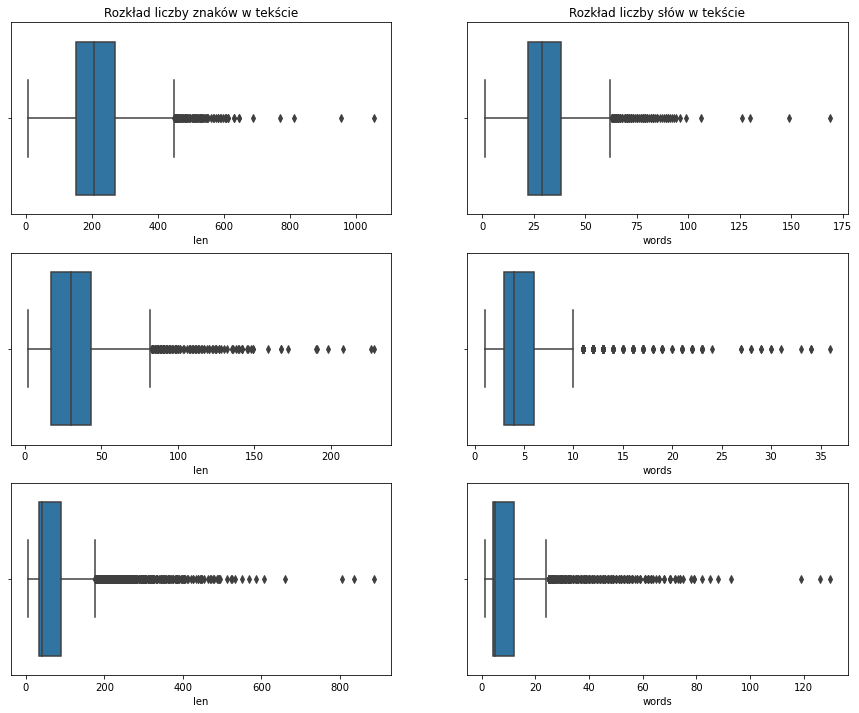

In [16]:
fig, axs = plt.subplots(3, 2, figsize = (15, 12))

sns.boxplot(data = fin, x = 'len', ax = axs[0,0])
sns.boxplot(data = fin, x = 'words', ax = axs[0,1])

sns.boxplot(data = ind, x = 'len', ax = axs[1,0])
sns.boxplot(data = ind, x = 'words', ax = axs[1,1])

sns.boxplot(data = imp, x = 'len', ax = axs[2,0])
sns.boxplot(data = imp, x = 'words', ax = axs[2,1])

axs[0,0].set_title('Rozkład liczby znaków w tekście')
axs[0, 1].set_title('Rozkład liczby słów w tekście')
plt.show()

Najkrótsze są teskty z kolumny INDICATION, teskty z FINDINGS i IMPRESSION są podobnej długości,najdłuższe są teskty z FINDINGS.

### "Flesh reading ease" oraz "Flesh-Kincaid grade level" dla danych tekstowych - jak łatwe do czytania

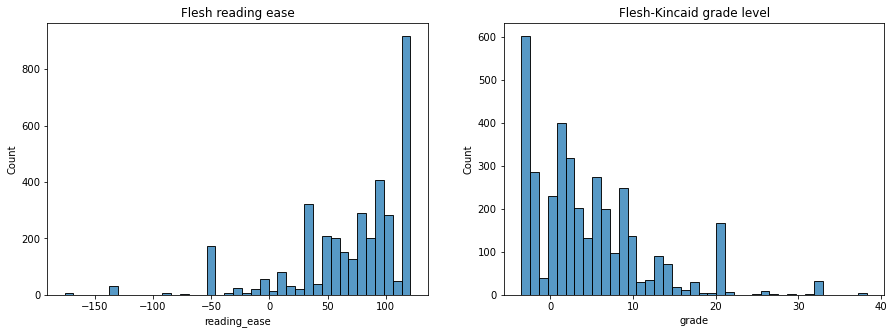

In [17]:
ease(ind)

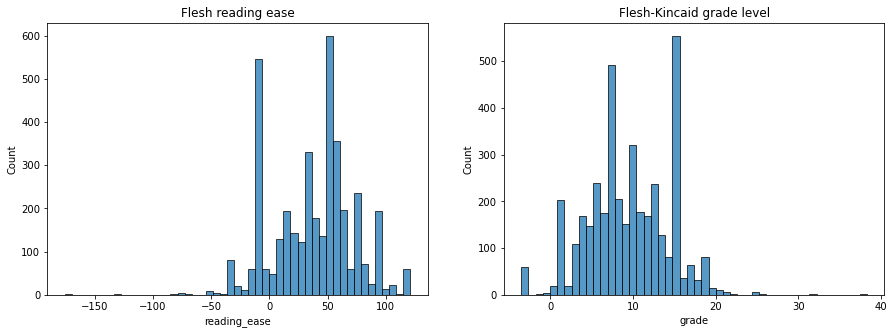

In [18]:
ease(imp)

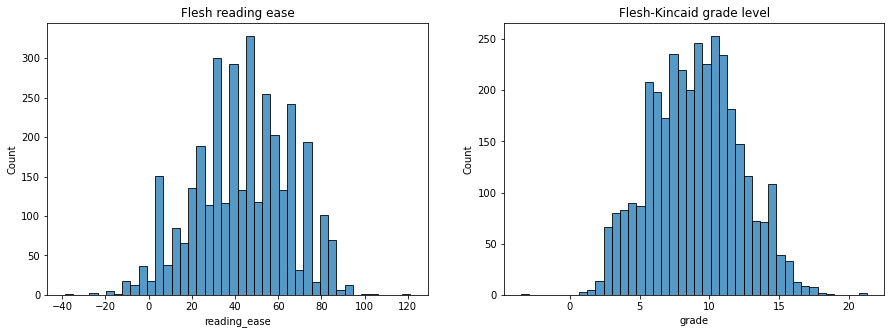

In [19]:
ease(fin)

Flesh-Kincaid reading ease -> im mniejszy tym trudniej.

Teskty z FINDINGS, są najdłuższe i za razem najłatwiesze do przeczytania. Ma to sens biorąc pod uwagę, że np. INDICATION to w wielu przypadkach jedynie zwięzła diagnoza.

Flesh-Kincaid grade level -> im większy tym trudniej, uznaje krótsze teksty z INDICATION i IMPRESSION za łatwiejsze do przeczytania.

### w opisach tekstowych popularne słowa

In [20]:
# zmoana tesktów na ramkę ze słowami

def vect(data):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data)
    return pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())


In [21]:
ind['INDICATION'] = cleaning(ind['INDICATION'])

ind_en = vect(ind['INDICATION'])

ind_en

aam  abd  abdomen  abdominal  ablation  abnormal  abnormality  about  \
0       0    0        0          0         0         0            0      0   
1       0    0        0          0         0         0            0      0   
2       0    0        0          0         0         0            0      0   
3       0    0        0          0         0         0            0      0   
4       0    0        0          0         0         0            0      0   
...   ...  ...      ...        ...       ...       ...          ...    ...   
3686    0    0        0          0         0         0            0      0   
3687    0    0        0          0         0         0            0      0   
3688    0    0        0          0         0         0            0      0   
3689    0    0        0          0         0         0            0      0   
3690    0    0        0          0         0         0            0      0   

      abscess  abscesses  ...  xiphoid  xol  xray  year  years  yellowish  \
0           0          0  ...        0    0     0     0      0          0   
1           0          0  ...        0    0     0     0      0          0   
2           0          0  ...        0    0     0     1      0          0   
3           0          0  ...        0    0     0     0      0          0   
4           0          0  ...        0    0     0     0      0          0   
...       ...        ...  ...      ...  ...   ...   ...    ...        ...   
3686        0          0  ...        0    0     0     1      0          0   
3687        0          0  ...        0    0     0     1      0          0   
3688        0          0  ...        0    0     0     1      0          0   
3689        0          0  ...        0    0     0     0      0          0   
3690        0          0  ...        0    0     0     1      0          0   

      yesterday  yof  yr  yrs  
0             0    0   0    0  
1             0    0   0    0  
2             0    0   0    0  
3             0    0   0    0  
4             0    0   0    0  
...         ...  ...  ..  ...  
3686          0    0   0    0  
3687          0    0   0    0  
3688          0    0   0    0  
3689          0    0   0    0  
3690          0    0   0    0  

[3691 rows x 1215 columns]

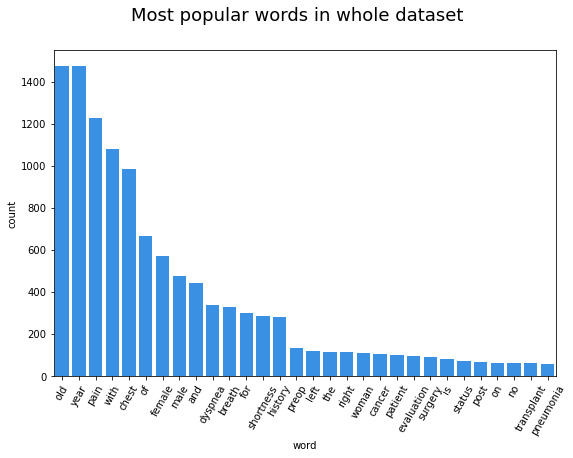

In [22]:
pop_words(ind_en)

['about', 'after', 'all', 'along', 'also', 'always', 'an', 'and', 'anything', 'are', 'around', 'at', 'back', 'be', 'been', 'before', 'behind', 'below', 'both', 'but', 'by', 'ca', 'could', 'does', 'due', 'eight', 'few', 'five', 'for', 'from', 'further', 'get', 'has', 'have', 'he', 'in', 'into', 'is', 'it', 'last', 'many', 'may', 'more', 'mostly', 'no', 'not', 'now', 'of', 'on', 'once', 'one', 'onto', 'or', 'other', 'otherwise', 'out', 'over', 'per', 'please', 're', 'several', 'she', 'side', 'since', 'six', 'some', 'than', 'that', 'the', 'this', 'three', 'throughout', 'to', 'two', 'under', 'up', 'us', 'using', 'very', 'was', 'well', 'who', 'will', 'with', 'without']
85


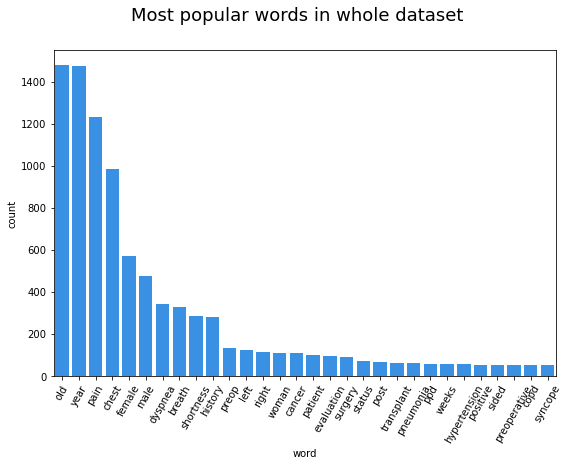

In [23]:
# usuwanie stopwords

ind['INDICATION'] = cleaning(ind['INDICATION'])
ind_en = vect(ind['INDICATION'])

stopwords, ind_en = stopw(ind_en)

pop_words(ind_en)

['about', 'above', 'after', 'again', 'all', 'almost', 'along', 'already', 'also', 'although', 'amount', 'an', 'and', 'another', 'any', 'are', 'as', 'at', 'be', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'cannot', 'could', 'does', 'due', 'either', 'elsewhere', 'few', 'first', 'for', 'from', 'further', 'has', 'have', 'here', 'however', 'if', 'in', 'into', 'is', 'it', 'its', 'less', 'may', 'more', 'most', 'mostly', 'no', 'none', 'not', 'now', 'of', 'on', 'one', 'only', 'or', 'other', 'otherwise', 'out', 'over', 'part', 'per', 'perhaps', 'please', 'regarding', 'same', 'see', 'several', 'she', 'should', 'show', 'side', 'since', 'some', 'something', 'than', 'that', 'the', 'then', 'there', 'these', 'this', 'those', 'though', 'three', 'through', 'throughout', 'to', 'top', 'two', 'under', 'unless', 'until', 'up', 'very', 'was', 'well', 'were', 'whether', 'which', 'whose', 'will', 'with', 'within', 'without', 'would', 'your']
114


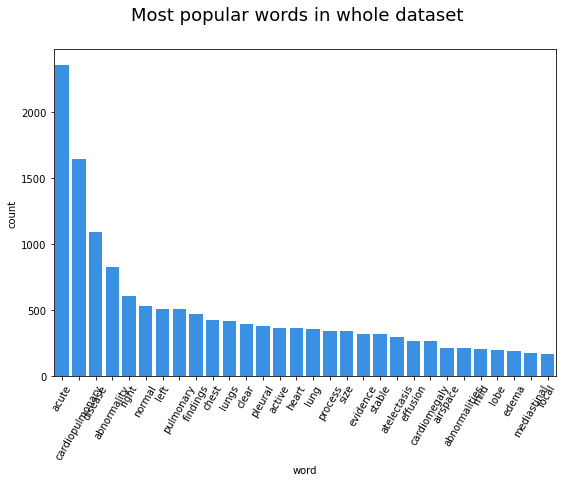

In [24]:
# usuwanie stopwords

imp['IMPRESSION'] = cleaning(imp['IMPRESSION'])
imp_en = vect(imp['IMPRESSION'])

stopwords, imp_en = stopw(imp_en)

pop_words(imp_en)

['about', 'above', 'after', 'again', 'all', 'along', 'already', 'also', 'although', 'amount', 'an', 'and', 'another', 'any', 'are', 'around', 'as', 'at', 'back', 'be', 'become', 'been', 'behind', 'below', 'besides', 'between', 'beyond', 'both', 'but', 'by', 'cannot', 'could', 'do', 'does', 'due', 'either', 'except', 'few', 'first', 'for', 'from', 'full', 'further', 'has', 'have', 'he', 'however', 'if', 'in', 'into', 'is', 'it', 'its', 'last', 'less', 'may', 'more', 'most', 'mostly', 'my', 'no', 'not', 'now', 'of', 'on', 'once', 'one', 'only', 'or', 'other', 'otherwise', 'over', 'part', 'perhaps', 'please', 're', 'same', 'see', 'seems', 'several', 'she', 'should', 'show', 'side', 'since', 'six', 'some', 'than', 'that', 'the', 'there', 'these', 'they', 'third', 'this', 'though', 'three', 'through', 'throughout', 'to', 'top', 'towards', 'two', 'under', 'up', 'upon', 'very', 'was', 'we', 'well', 'were', 'whether', 'which', 'whose', 'with', 'within', 'without', 'would', 'your']
119


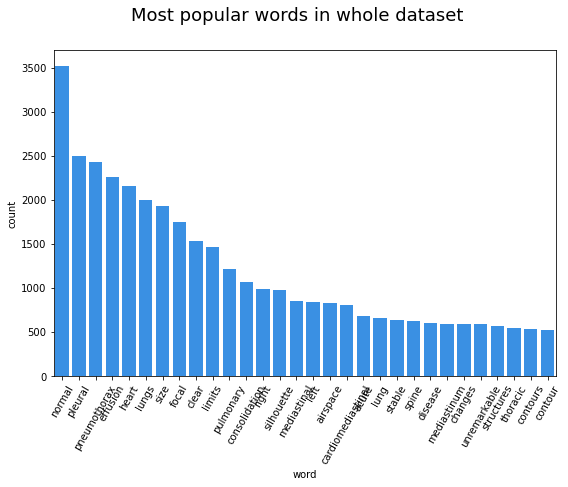

In [25]:
# usuwanie stopwords

fin['FINDINGS'] = cleaning(fin['FINDINGS'])
fin_en = vect(fin['FINDINGS'])

stopwords, fin_en = stopw(fin_en)

pop_words(fin_en)

Najpopularniesze słowa dla INDICATION to year, old, pain, chest, female, male, dyspnea, breath. Year i old nic właściwie nie znaczą, ponieważ sam wiek jest zanonimizowany.

Najpopularniejsze słowa dla IMPRESSION to acute, cardiopulmonasy, diesase, abnormality, night, normal, wskazuje to na co pacjenci zwracają uwagę.

Dla Findings najpopularnijsze są normal, pleural, pneumothorax, effusion, heart, luns, size. Normal na pierwszym miejscu wskazuje istnienie wielu przypadków bez zmian płucnych

### najpopularniejsze słowa opisujące choroby

In [26]:
# ramka zawierająca popularne choroby płuc, nazwy chorób ze strony pobrałem ze strony
# https://www.lung.org/lung-health-diseases/lung-disease-lookup

diesases = pd.read_csv('a.csv').drop('Unnamed: 0', axis = 1)
diesases.head(5)

d
0  acute respiratory distress syndrome 
1         alpha  antitrypsin deficiency
2                            asbestosis
3                         aspergillosis
4                                asthma

In [27]:
d1 = np.intersect1d(np.array(ind_en.columns),np.array(diesases).T[0])
ind_en[d1].sum(axis=0)

asthma            48
bronchiectasis     3
copd              51
emphysema          7
flu                1
histoplasmosis     1
pneumonia         60
sarcoidosis       21
tb                34
tuberculosis      27
dtype: int64

In [28]:
d1 = np.intersect1d(np.array(imp_en.columns),np.array(diesases).T[0])
imp_en[d1].sum(axis=0)

bronchiectasis      5
bronchiolitis       3
copd               35
emphysema          71
histoplasmosis      3
pneumonia         151
sarcoidosis         9
tb                  5
tuberculosis       54
dtype: int64

In [29]:
d1 = np.intersect1d(np.array(fin_en.columns),np.array(diesases).T[0])
ind_en[d1].sum(axis=0)

bronchiectasis     3
copd              51
emphysema          7
histoplasmosis     1
pneumonia         60
tb                34
tuberculosis      27
dtype: int64

Nazwy chorób, które najczęściej występują w zbiorach to pneunomia, tuberculosis (tb), copd, asthma, emphysema

### popularne n-gramy (usunąć z nich potem stopwords)

In [30]:
words = []
for i in ind['INDICATION']:
    words = np.concatenate([words, i.split()])

(pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]

(year, old, female)        558
(year, old, male)          468
(pain, year, old)          336
(old, female, with)        307
(shortness, of, breath)    283
(old, male, with)          259
(chest, pain, year)        255
(year, old, with)          249
(with, chest, pain)        246
(year, old, woman)         110
dtype: int64

dominują tu wyrażenia z year i old, jedymym ciekawym widocznym przypadkiem jest shortness of breath.

In [31]:
words2 = []
for i in imp['IMPRESSION']:
    words2 = np.concatenate([words2, i.split()])

(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

(no, acute, cardiopulmonary)               1322
(acute, cardiopulmonary, abnormality)       642
(disease, no, acute)                        367
(cardiopulmonary, abnormality, no)          272
(abnormality, no, acute)                    268
(acute, cardiopulmonary, disease)           256
(acute, cardiopulmonary, findings)          230
(no, evidence, of)                          230
(acute, cardiopulmonary, abnormalities)     177
(cardiopulmonary, disease, no)              164
dtype: int64

In [32]:
(pd.Series(nltk.ngrams(words2, 4)).value_counts())[:10]

(no, acute, cardiopulmonary, abnormality)      589
(acute, cardiopulmonary, abnormality, no)      270
(disease, no, acute, cardiopulmonary)          241
(no, acute, cardiopulmonary, findings)         213
(cardiopulmonary, abnormality, no, acute)      210
(no, acute, cardiopulmonary, disease)          193
(abnormality, no, acute, cardiopulmonary)      192
(no, acute, cardiopulmonary, abnormalities)    176
(acute, cardiopulmonary, disease, no)          146
(cardiopulmonary, disease, no, acute)          132
dtype: int64

Najpopularniejsze słowa wskazują na brak cieżkich zmian, najczęśniej krążeniowo oddechowych

In [33]:
words3 = []
for i in fin['FINDINGS']:
    words3 = np.concatenate([words3, i.split()])

(pd.Series(nltk.ngrams(words3, 3)).value_counts())[:10]

(within, normal, limits)        1362
(lungs, are, clear)             1102
(the, lungs, are)               1048
(there, is, no)                  906
(pleural, effusion, or)          840
(effusion, or, pneumothorax)     787
(or, pleural, effusion)          545
(no, pleural, effusion)          538
(are, within, normal)            528
(pneumothorax, or, pleural)      521
dtype: int64

Tutaj opisy również wskazują, że wielu przypadkach w płucach nie ma zmian chorobowych.

### słowa kluczowe 

Niestey ta biblioteka działa bardzo wolno, po ponad godzinie wykonywania pojawił się błąd, więc niestety nie sprawdziłem słów kluczowych.

In [34]:
def pke_keyphrases(text):
    extractor = pke.unsupervised.TopicRank()
    extractor.load_document(input=text, language='en')
    extractor.candidate_selection()
    extractor.candidate_weighting()
    keyphrases = extractor.get_n_best(n=10)

    return keyphrases

In [35]:
imp['key'] = imp['IMPRESSION'].apply(lambda x : '' if len(x) == 0 else pke_keyphrases(x.strip())[0][0])
ind['key'] = ind['INDICATION'].apply(lambda x : '' if len(x) == 0 else pke_keyphrases(x.strip())[0][0])
fin['key'] = fin['FINDINGS'].apply(lambda x : '' if len(x) == 0 else pke_keyphrases(x.strip())[0][0])

KeyboardInterrupt: 